# Section 2

## Stange algorithm

In [4]:
def smoothness(residue,b):
    f=[]
    p=2 
    i=0
    while residue!=1 and i<b:
        exponent=0
        while p.divides(residue):
            residue=residue/p           
            exponent+=1
        f.append(exponent)
        p=next_prime(p)
        i+=1
    g=False
    if residue==1:
        g=vector(ZZ,b)
        g[:len(f)]=f
    return g,residue


# %load_ext line_profiler
# %lprun -f smoothness  smoothness(n,b)
# %timeit SK_method(n,g,b)    
# %load_ext line_profiler

In [5]:
import numpy as np
def Stange_method(n,g,b=10,c=10,keepFT=False):    
    # n = composite modulus
    # g = base g<n
    # b = size of factor base
    # c = number of additional relations
    # OUTPUT:  order of g mod n
    
    #-------------------phase 1: Relation finding------------------------- 
    counter= 0               # number of relations found
    rand_x=[]                          
    FT=matrix(b,b+c,sparse=True)   # relation Matrix           
    while counter<b+c :
        
        x=randint(1,n)
        while x in rand_x:
            x=randint(1,n)
        
        residue = ZZ(Mod(g,n)^x)
        
        f,residue=smoothness(residue,b)
        #------------------------------Append the vector if the relationship is found---------------------
        if residue==1:
#             print(g,"^{",x,"}&=",latex(factor(ZZ(Mod(g,n)^x))),",\\\\")
            f=vector(f)
            rand_x.append(x)
            FT[:,counter]=f
            counter+=1
    #------------------------------phase 2: Linear Algebra---------------------------------------
#     print(latex(FT))
    kernel_basis=FT.right_kernel().basis()[:c] # obtain the basis
#     print(latex(matrix(kernel_basis)))
    
        #-----------------------Find alphas--------------------------------
    alpha=[]
    for base_vec in kernel_basis:
        alp=np.dot(base_vec,rand_x) 
        alpha.append(alp)  #list of all the alphas
        
        
    #----------------------phase 3: Computing order of g mod n----------------------------
#     print(latex(alpha))
    order=Integer(gcd(alpha)) 
    
    if keepFT:
        return order,FT,rand_x
    return order

## Optimal b testing

In [6]:
from time import time
import numpy as np
import matplotlib.pyplot as plt



def test_optimal_b(n,g,bounds,y=5):
    times=[]
    for b in range(bounds[0],bounds[1]):
        summ=0
        for i in range(y):
            tock=time()
            Stange_method(n,g,b)
            tick=time()
            summ+=tick-tock
        summ/=5
        times.append(summ)
    return range(bounds[0],bounds[1]),times


def opt_b(n):
    C_n=sqrt(2 /  ( ln(n) * ln(ln(n)) )  )
    return ceil(C_n*exp(1/C_n))

opt_b(537)


Integers=[537, 765, 8585, 19053, 61453, 101371, 199989, 247251, 484957, 671015, 871933, 907423, 1744953, 1946725, 2177645, 2381625, 3632763, 5001635, 7865455, 22653803]
# print(Int)


In [7]:
bounds=[1,50]
Integers=[537, 765, 8585, 19053, 61453, 101371, 199989, 247251, 484957, 671015, 871933, 907423, 1744953, 1946725, 2177645, 2381625, 3632763, 5001635, 7865455, 22653803]
# Integers=[537, 765, 8585, 19053, 61453, 101371, 199989, 871933, 2381625, 22653803]


# for h in Integers:
#     print(opt_b(h))
#     if opt_b(h)>15:
#         bounds=[8,50]
#     else: bounds=[1,50]
#     g=randint(2,h-1)
#     while gcd(g,h)!=1:
#         g=randint(2,h-2)
# #     print(g,"g")
#     res1,res2=test_optimal_b(h,g,bounds,5) 
    
#     plt.plot(res1,res2)
#     plt.title(f'running time for n={h} as b varies')
#     plt.plot(opt_b(h),res2[opt_b(h)-bounds[0]],'x',label="theoretical approximation of the optimal value of b")
#     plt.legend()
#     plt.show()

    
# print("Done")

# Section 4

## Method 1

In [8]:
def Method_1(n,b=10,c=10,keepFT=False):
    for g in range(2,n-1):
        if gcd(g,n)!=1:
            return gcd(g,n),n/gcd(g,n)
        order=Stange_method(n,g,b,c,keepFT)
        if order%2==0 and ZZ(Mod(g^(order/2),n))!=n-1:
                return gcd(g^(order/2)-1,n),n/gcd(g^(order/2)-1,n)

    


## Method 2

In [9]:
def eta(q,B):
    i=1
    while q^i<=B:
        i+=1
    return i-1


def Method_2(n,b=10,c=10,keepFT=False):
    g=randint(2,n-1)
    if gcd(g,n)!=1:
        return gcd(g,n),n/gcd(g,n)
    
    order=Stange_method(n,g,b,c,keepFT)
    m=2*n.nbits()
    prod=1
    for p in prime_range(m):
        q=eta(p,m)
        prod*=p^q
    R=order*prod
    twopower=(int(R.binary(),2) & (~(int( (R- 1).binary() ,2)) ) )
    z=R/twopower
    
    for x in range(2,n-1):
        if gcd(x,n)!=1:
            return gcd(x,n),n/gcd(x,n)
        b=ZZ(Mod(x,n)^z)
        
        d=gcd(ZZ(Mod(b-1,n)),n)
        if d!=1:
            return d,n/d
        i=0
        while i<log(twopower,2) and b!=1:
            b=ZZ(Mod(b,n)^2)
            d=gcd(b-1,n)
            if d!=1 and d!=n:
                return d,n/d
            i+=1
            

## Comparison between two methods

In [10]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

def running_time(f,n,b=10,c=10,keepFT=False,y=50):
    summ=0
    for i in range(y):
        tock=time()
        fact1,fact2=f(n,b,c,keepFT)
        if not fact1*fact2==n: 
            print("Error",n,b)
            break
        tick=time()
        summ+=tick-tock
    summ/=y
    return summ

# print(Integers)




In [11]:
# axis1=[]
# axis2=[]
# for n in Integers:
#     print("n=",n)
#     b=opt_b(n)
#     time1=running_time(Method_1,n,b)
#     axis1.append(time1)
#     print("First done")
#     time2=running_time(Method_2,n,b)
#     axis2.append(time2)
#     print("Second done")
# plt.plot(Integers,axis1,label="Method 1")
# plt.plot(Integers,axis2,label="Method 2")
# plt.legend()
# plt.show()

In [12]:
# plt.plot(Integers,axis1,label="Method 1")
# plt.legend();plt.show()
# plt.plot(Integers,axis2,color="orange",label="Method 2")
# plt.legend();plt.show()


# y=10
# for i in range(20/y):
#     plt.plot(Integers[i*y:(i+1)*y],axis1[i*y:(i+1)*y],label="Method 1")
#     plt.plot(Integers[i*y:(i+1)*y],axis2[i*y:(i+1)*y],label="Method 2")
#     plt.legend()
#     plt.show()

# Section 5

## Single Kernel Method

In [13]:
import numpy as np

def SK_method(n,g,b=10):    
    # n = composite modulus
    # g = base g<n
    # b = size of factor base
    # OUTPUT:  factors of n
    
    #-------------------phase 1: Relation finding------------------------- 
    rank=0
    rand_x=[]                          
    F=[]   # relation Matrix

    while rank==0 :
        x=randint(1,n-1)
        while x in rand_x:
            x=randint(1,n-1)
        
        residue = ZZ(Mod(g,n)^x)
        f,residue=smoothness(residue,b)

        #------------------------------Append the vector if the relationship is found---------------------
        if residue==1:
#              print(g,"^{",x,"}&=",latex(factor(ZZ(Mod(g,n)^x))),",\\\\")
            rand_x.append(x)
            F.append(f)  

            #--------------- Periodically compute kernel----------------------------

            rank=matrix(F,sparse=True).transpose().right_kernel().rank()

    kernel_basis=matrix(F).transpose().right_kernel().basis()
    [order]=abs(np.dot(kernel_basis,rand_x))
    return ZZ(order)

## Method 1.1

In [14]:
def Method_1_1(n,b=10,keepFT=False):
    for g in range(2,n-1):
        if gcd(g,n)!=1:
            return gcd(g,n),n/gcd(g,n)
        b=opt_b(n)
        order=SK_method(n,g,b)
        while order==0:
            order=SK_method(n,g,b)
            
        if order%2==0:
            while M==1:
                order/=2
                M=ZZ(Mod(g^order,n))            
            if M!=n-1 and M!=1:
                return gcd(M-1,n) , n/gcd(M-1,n)
                

## Method 2.1

In [15]:
def Method_2_1(n,b=10,c=10,keepFT=False):
    g=randint(2,n-1)
    if gcd(g,n)!=1:
        return gcd(g,n),n/gcd(g,n)
    
    b=opt_b(n)
    R=SK_method(n,g,b)
    twopower=(int(R.binary(),2) & (~(int( (R- 1).binary() ,2)) ) )
    if twopower!=0:
        z=R/twopower
    else: z=R

    for x in range(2,n-1):
        if gcd(x,n)!=1:
            return gcd(x,n),n/gcd(x,n)
        b=ZZ(Mod(x,n)^z)
        
        d=gcd(ZZ(Mod(b-1,n)),n)
        if d!=1:
            return d,n/d
        i=0
        while i<log(twopower,2) and b!=1:
            b=ZZ(Mod(b,n)^2)
            d=gcd(b-1,n)
            if d!=1 and d!=n:
                return d,n/d
            i+=1

## Compare order vs SK

In [16]:
def order_running_time(f,n,g,b=10,y=50):
    summ=0
    for i in range(y):
        tock=time()
        order=f(n,g,b)
        tick=time()
        summ+=tick-tock
    summ/=y
    return summ

In [17]:
# axis1=[]
# axis2=[]
# i=0
# for n in Integers:
#     i+=1
#     print(i,"/20")
#     b=opt_b(n)
#     g=randint(2,n-1)
#     while gcd(g,n)!=1:
#         g=randint(2,n-1)
#     time1=order_running_time(Stange_method,n,b,y=10)
#     axis1.append(time1)
#     print("First done")
#     time2=order_running_time(SK_method,n,b,y=10)
#     axis2.append(time2)
#     print("Second done")

# plt.plot(Integers,axis1,label="Stange")
# plt.plot(Integers,axis2,label="SK_method")
# plt.legend()
# plt.show()

## Comparison between Method 1.1 and Method 2.1

In [18]:
from time import time
import numpy as np
import matplotlib.pyplot as plt




def running_time(f,n,b=10,keepFT=False,y=50):
    summ=0
    for i in range(y):
        tock=time()
        fact1,fact2=f(n,b,keepFT)
        if not fact1*fact2==n: 
            break
        tick=time()
        summ+=tick-tock
    summ/=y
    return summ



In [19]:

# axis1=[]
# axis2=[]
# i=0
# for n in Integers:
#     i+=1
#     print(i,"/20")
#     b=opt_b(n)
#     time1=running_time(Method_1_1,n,b)
#     axis1.append(time1)
#     print("First done")
#     time2=running_time(Method_2_1,n,b)
#     axis2.append(time2)
#     print("Second done")

# plt.plot(Integers,axis1,label="Method 1.1")
# plt.plot(Integers,axis2,label="Method 2.1")
# plt.legend()
# plt.show()

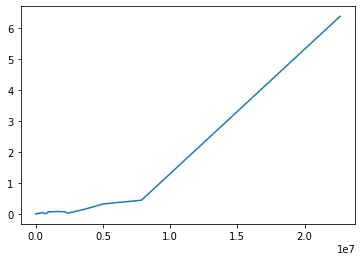

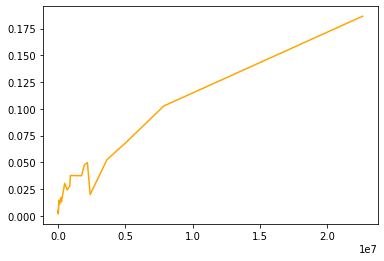

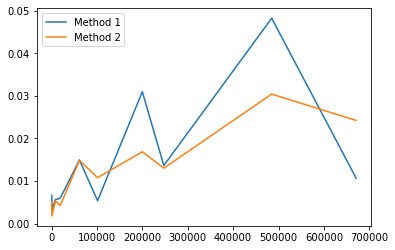

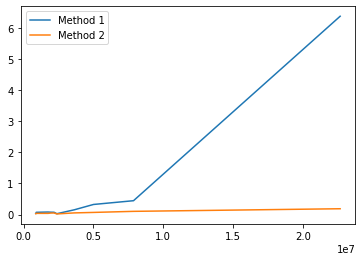

In [20]:
import matplotlib.pyplot as plt

axis1=[0.006625533103942871, 0.0033301687240600585, 0.005606155395507812, 0.005933589935302734, 0.014932088851928711, 0.005353422164916992, 0.03095940113067627, 0.01361478328704834, 0.04821771144866943, 0.01065074920654297, 0.034699687957763674, 0.07145815849304199, 0.08052495956420898, 0.07479928970336915, 0.07287202835083008, 0.02633876323699951, 0.1531623411178589, 0.3244387149810791, 0.4454440450668335, 6.387570548057556]
axis2=[0.005074677467346192, 0.001787104606628418, 0.005314569473266601, 0.00422727108001709, 0.014820127487182618, 0.010773801803588867, 0.01685565948486328, 0.013003802299499512, 0.030400261878967286, 0.024218358993530274, 0.027966699600219726, 0.037648520469665527, 0.03747704982757569, 0.047498040199279785, 0.04976957321166992, 0.019881691932678223, 0.05252223968505859, 0.06800042629241944, 0.10267131328582764,0.18651556491851806]

plt.plot(Integers,axis1,label="Alg. 5")
# plt.legend();
plt.show()
plt.plot(Integers,axis2,color="orange",label="Alg. 6")
# plt.legend();
plt.show()


y=10
for i in range(20/y):
    plt.plot(Integers[i*y:(i+1)*y],axis1[i*y:(i+1)*y],label="Method 1")
    plt.plot(Integers[i*y:(i+1)*y],axis2[i*y:(i+1)*y],label="Method 2")
    plt.legend()
    plt.show()

## Comparison between Method 1 and Method 2.1

1 /20
2 /20
3 /20
4 /20
5 /20
6 /20
7 /20
8 /20
9 /20
10 /20
11 /20
12 /20
13 /20
14 /20
15 /20
16 /20
17 /20
18 /20
19 /20
20 /20


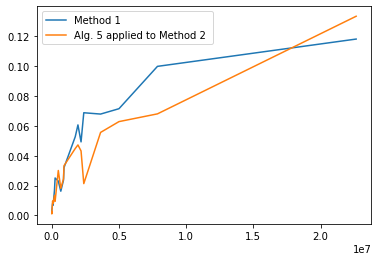

In [23]:
axis1=[]
axis2=[]
i=0
for n in Integers:
    i+=1
    print(i,"/20")
    b=opt_b(n)
    time1=running_time(Method_1,n,b)
    axis1.append(time1)
#     print("First done")
    time2=running_time(Method_2_1,n,b)
    axis2.append(time2)
#     print("Second done")
    
    
plt.plot(Integers,axis1,label="Method 1")
plt.plot(Integers,axis2,label="Alg. 5 applied to Method 2 ")
plt.legend()
plt.show()


In [22]:
j=0
k=0
for i in range(len(axis1)):
    if axis1[i]>axis2[i]:
        j+=1
    else: k+=1
print(j,k)

13 7


In [ ]:
# import numpy as np
# #Index calculus

# def IC(n,g,order,y,b=10,c=10):    
#     # n = composite modulus
#     # g = base g<n
#     # b = size of factor base
#     # c = number of additional relations
#     # OUTPUT:  factors of n
    
#     #-------------------phase 1: Relation finding------------------------- 
#     relsFound = 0               # number of relations found
#     relsDesired=b+c   # number of relations desired
#     rand_x=[]                          
#     FT=matrix(b,b+c)   # relation Matrix

#     x=0
#     while( relsFound < relsDesired ):
        
#         x+=1
        
#         residue = ZZ(Mod(g,n)^x)
#         f=[]

#         #-------------------Attempt factorisation of g^x------------------------------
#         for p in primes_first_n(b):
#             exponent=0
#             while Mod(residue,p)==0:
#                 residue=residue/p           
#                 exponent+=1
#             f.append(exponent)
#         #------------------------------Append the vector if the relationship is found---------------------
#         if residue==1:
# #             print(g,"^{",x,"}&=",latex(factor(ZZ(Mod(g,n)^x))),",\\\\")
#             f=vector(f)
#             rand_x.append(x)
#             FT[:,relsFound]=f
#             relsFound+=1

#     #------------------------------phase 2: Linear Algebra---------------------------------------
#  # solve a=Fp

#     F=FT.transpose()    
#     Fring=F.change_ring(Integers(order))
#     randring=vector(rand_x).change_ring(Integers(order))
#     logp=Fring\randring     
#     print(f"P={logp}")
    
#         #-----------------------phase 3: Find one last relation--------------------------------
# # find relatiob yg^k=g^xg^k
#     k=-1
#     residue=0
#     while residue!=1:
#         k+=1
#         residue=Mod(y*(g^k),n)
#         f=[]
#         for p in primes_first_n(b):
#             exponent=0
#             while Mod(residue,p)==0:
#                 residue=residue/p           
#                 exponent+=1
#             f.append(exponent)
#     print(f,k)
#     return np.dot(logp,f)-k
            

# n=103
# g=572
# order=Mod(g,n).multiplicative_order()
# print(f"the order is {order}")

# y=572^28
# power=IC(n,g,order,y,b=1,c=0)
# print(f"the log computed is {power}")
# print(Mod(g,n)^power==Mod(y,n))
# # print(Mod(g,n)^power)

In [ ]:
# def IC_factor_method(n,b=10,c=10):    
#     g=2
#     if gcd(g,n)!=1:
#         return gcd(g,n),n/gcd(g,n)
    
#     (order,FT,rand_x)=Stange_method(n,g,b,c,True) 
    
#     if order%2==0:
#         factors=EO_method(n,g,order)
#         if factors:
#             return factors
     
#     print(order)
#     F=FT.transpose()   
#     Fring=F.change_ring(Integers(order))
#     randring=vector(rand_x).change_ring(Integers(order))
#     logp=Fring\randring
#     print(logp)
#     for j in range(len(logp)):
#         print(Mod(2^logp[j],n))
        
        
#     # use logp to get new order
#     for i in range(3,4): #----_-_-_-----_---_- change this back
#         if gcd(i,n)!=1:
#             return gcd(i,n),n/gcd(i,n)
#         print(f"i is {i}")
#         #-------------Find one relation------------------------
        
#         k=-1
#         residue=0
#         while residue!=1:
#             k+=1
#             residue=Mod(i*(g^k),n)
#             print(residue)
#             f=[]
#             for p in primes_first_n(b):
#                 exponent=0
#                 while Mod(residue,p)==0:
#                     residue=residue/p           
#                     exponent+=1
#                 f.append(exponent)
#         print(f,residue)
#         log_g_i=np.dot(logp,f)-k
#         print(f"log_g(i)={log_g_i}")
#         print(f"the result is {g}^{log_g_i}={i}",Mod(g,n)^log_g_i,i)
#         #-------------------log_g(1)/log_g(i)=log_i(1)-----------------
#         order1=order/log_g_i
#         print(order1)
        
        
        
# n=4987*4993
# n=152942113

# n=105
# f1,f2=
# IC_factor_method(n,b=10,c=10)
# print(f1,f2,f1*f2==n)

# order=Mod(2,n).multiplicative_order()



the method above need that 2 generates 2,3,5,7 etc so that logp makes any sense.

In [ ]:

# #Ankeny bound c=1


# def bound(n):
#     for i in range(1,ceil(log(n, 2)^2)):
#         if kronecker_symbol(i,n)==-1:
#             return i

        
# for n in prime_range(5,3000):
#     print(bound(n))

